# CoderHouse - Grupo 7 - Analisis Univariado

* <b>Profesor:</b> David Romero Acosta

* <b>Tutoria:</b> Hector Ponce Schwarz

<b>Alumnos:</b>
* Juan Pascual
* Lucas Ariel Saavedra
* Bartolome Oscar Meritello
* Jose Mornaghi

Arrancamos el analisis importando todo lo que necesitamos y desactivamos los carteles de Warnings. Tambien, creamos las funciones que vamos a usar en todo el notebook para ahorrar codigo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.impute import KNNImputer
warnings.filterwarnings("ignore")

In [2]:
data_directory = "./data/"
stroke_dataset = pd.read_csv(data_directory + "stroke.csv")
stroke_dataset = stroke_dataset.drop("id", axis=1) #Sacamos este metadato

def plot_numerical_serie(dataset, column_name):
    fig,axes = plt.subplots(nrows=1,ncols=2,dpi=120,figsize = (8,4))

    plot0=sns.distplot(dataset[dataset[column_name]!=0][column_name],ax=axes[0],color='green')
    # axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[0].set_title(f'Distribution of {column_name}',fontdict={'fontsize':8})
    axes[0].set_xlabel(f'{column_name} Class',fontdict={'fontsize':7})
    axes[0].set_ylabel('Count/Dist.',fontdict={'fontsize':7})
    plt.tight_layout()

    plot1=sns.boxplot(dataset[dataset[column_name]!=0][column_name],ax=axes[1],orient='v')
    axes[1].set_title('Numerical Summary',fontdict={'fontsize':8})
    axes[1].set_xlabel(column_name,fontdict={'fontsize':7})
    axes[1].set_ylabel(column_name,fontdict={'fontsize':7})
    plt.tight_layout()

    plt.show()

def plot_pie(dataset, group_by_variable, output_variable):
    comparison = dataset.groupby(group_by_variable).count()[output_variable]
    plt.pie(x=comparison, labels=comparison.index, autopct='%1.2f%%')
    plt.title(f'{group_by_variable} comparison')
    plt.show()

def frequency_dataframe(dataset, variable):
    frec = dataset[variable].value_counts()
    frec_df = pd.DataFrame(frec)

    frec_df.rename(columns={variable:'Frec_abs'},inplace=True)

    Frec_abs_val = frec_df["Frec_abs"].values
    acum = []
    valor_acum = 0
    for i in Frec_abs_val:
        valor_acum = valor_acum + i
        acum.append(valor_acum)

    frec_df["frec_abs_acum"] = acum

    frec_df["frec_rel_%"] = round(100 * frec_df["Frec_abs"]/len(stroke_dataset.smoking_status),4)

    Frec_rel_val = frec_df["frec_rel_%"].values

    acum = []

    valor_acum = 0

    for i in Frec_rel_val:
        valor_acum = valor_acum + i
        acum.append(valor_acum)

    frec_df["frec_rel_%_acum"] = acum
    
    return frec_df
    
stroke_dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
stroke_dataset.shape

(5110, 11)

## Datos imputados

In [4]:
stroke_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [5]:
stroke_dataset.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Observamos que hay valores de BMI (Indice de masa corporal) que no tenemos disponibles. Veamos que descripciones estadísticas obtenemos y luego imputamos los datos faltantes usando el metodo de KNN.

In [6]:
stroke_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [7]:
imputador = KNNImputer(n_neighbors=3, weights="uniform")
stroke_dataset['imputed_bmi'] = imputador.fit_transform(stroke_dataset[['bmi']])
stroke_dataset.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
imputed_bmi            0
dtype: int64

In [8]:
stroke_dataset.describe()[["bmi", "imputed_bmi"]].T

,count,mean,std,min,25%,50%,75%,max
bmi,4909.0,28.893237,7.854067,10.3,23.5,28.1,33.1,97.6
imputed_bmi,5110.0,28.893237,7.698018,10.3,23.8,28.4,32.8,97.6


Imputar no nos afecta el análisis y no perdemos filas. Guardamos el dataset para usarlo a futuro.

In [9]:
stroke_dataset = stroke_dataset.drop("bmi", axis = 1)
stroke_dataset = stroke_dataset.rename(columns={'imputed_bmi': 'bmi'})
stroke_dataset = stroke_dataset.drop(3116)
stroke_dataset.to_csv(data_directory + "stroke_imputed.csv", index=False)
stroke_dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi
0,Male,67.0,0,1,Yes,Private,Urban,228.69,formerly smoked,1,36.600000
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,never smoked,1,28.893237
2,Male,80.0,0,1,Yes,Private,Rural,105.92,never smoked,1,32.500000
3,Female,49.0,0,0,Yes,Private,Urban,171.23,smokes,1,34.400000
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,24.000000
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,never smoked,0,28.893237
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,never smoked,0,40.000000
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,never smoked,0,30.600000
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,formerly smoked,0,25.600000


## Análisis Univariado

Hacemos una descripción de cada una de las variables cuantitativas haciendo un histograma y un boxplot a cada una. A las cualitativas hicimos un grafico Pie.

In [10]:
stroke_dataset.bmi.describe()

count    5109.000000
mean       28.894508
std         7.698235
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

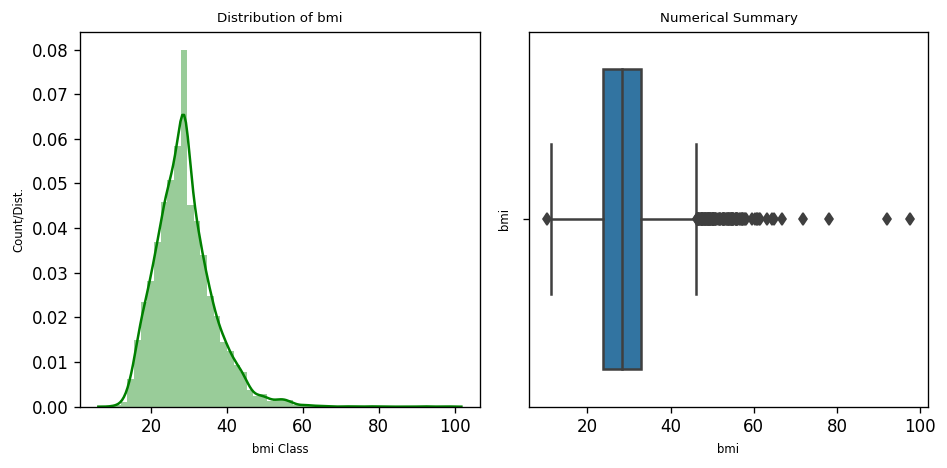

In [11]:
plot_numerical_serie(stroke_dataset, 'bmi')

Los analisis de bmi indican que los valores sobre 35 es obesidad extrema. Hay que analizar en el dataset si puede que algunos valores esten mal ingresados o no tengan sentido.

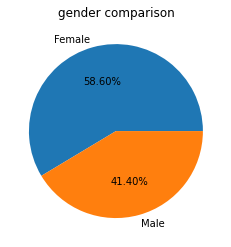

In [12]:
plot_pie(stroke_dataset, 'gender', 'stroke')

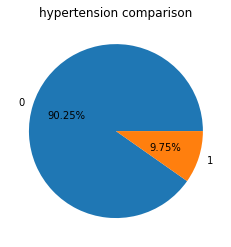

In [13]:
plot_pie(stroke_dataset, 'hypertension', 'stroke')

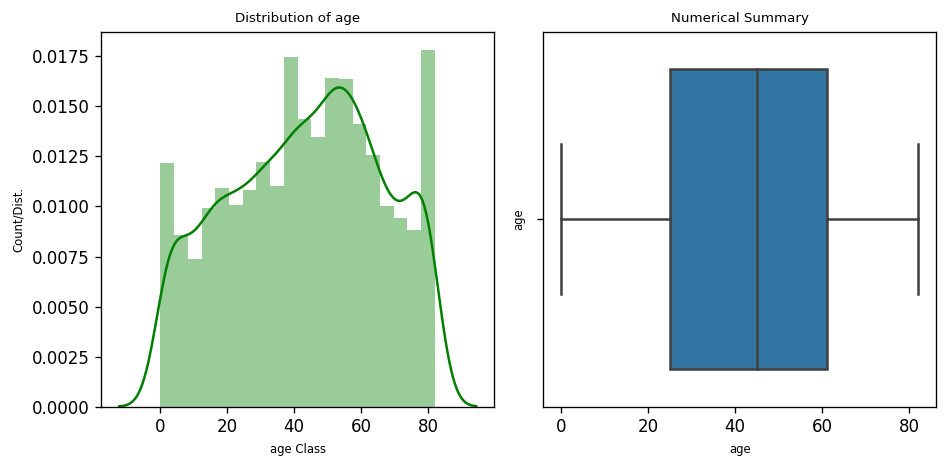

In [14]:
plot_numerical_serie(stroke_dataset, 'age')

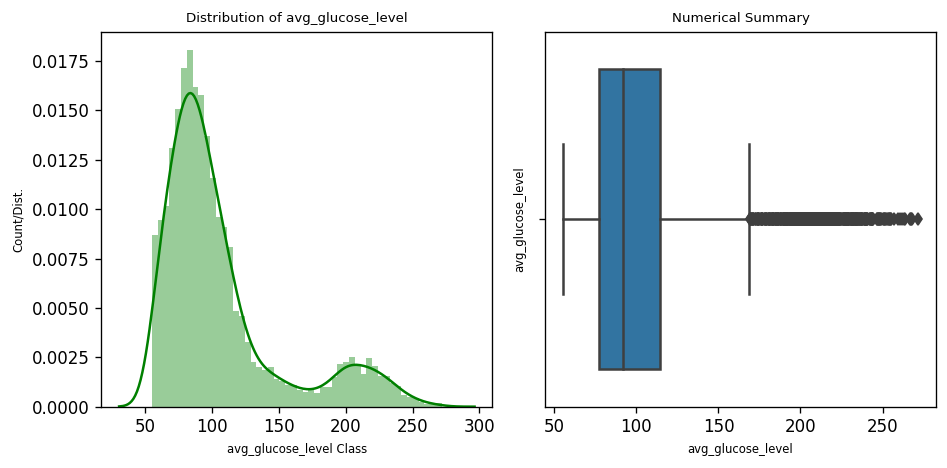

In [15]:
plot_numerical_serie(stroke_dataset, 'avg_glucose_level')

# Distribución de Frecuencias

In [16]:
frequency_dataframe(stroke_dataset, 'smoking_status')

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
never smoked,1892,1892,37.0327,37.0327
Unknown,1544,3436,30.2212,67.2539
formerly smoked,884,4320,17.3028,84.5567
smokes,789,5109,15.4433,100.0000


In [17]:
frequency_dataframe(stroke_dataset, 'gender')

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
Female,2994,2994,58.6025,58.6025
Male,2115,5109,41.3975,100.0000


In [18]:
frequency_dataframe(stroke_dataset, 'hypertension')

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
0,4611,4611,90.2525,90.2525
1,498,5109,9.7475,100.0000


In [19]:
frequency_dataframe(stroke_dataset, 'heart_disease')

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
0,4833,4833,94.5978,94.5978
1,276,5109,5.4022,100.0000


In [20]:
frequency_dataframe(stroke_dataset, 'ever_married')

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
Yes,3353,3353,65.6293,65.6293
No,1756,5109,34.3707,100.0000


In [21]:
frequency_dataframe(stroke_dataset, 'work_type')

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
Private,2924,2924,57.2323,57.2323
Self-employed,819,3743,16.0305,73.2628
children,687,4430,13.4469,86.7097
Govt_job,657,5087,12.8597,99.5694
Never_worked,22,5109,0.4306,100.0000


In [22]:
frequency_dataframe(stroke_dataset, 'Residence_type')

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
Urban,2596,2596,50.8123,50.8123
Rural,2513,5109,49.1877,100.0000


In [23]:
frequency_dataframe(stroke_dataset, 'stroke')

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
0,4860,4860,95.1262,95.1262
1,249,5109,4.8738,100.0000
